In [12]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
from IPython.display import clear_output

In [2]:
def move():
    '''function to pick a random direction to propagate

    Inputs:

        none

    Returns:

        dx: float
        
            normalized x direction of step

        dy: float

            normalized x direction of step

        dz: float

            normalized z direction of step

    '''

    #randomly sample theta
    theta=np.arccos(np.random.uniform(-1,1))

    #randomly sample phi
    phi=np.random.uniform(0,2*np.pi)

    #calculate random, unit vector given theta and phi
    dx=np.sin(theta)*np.cos(phi)
    dy=np.sin(theta)*np.sin(phi)
    dz=np.cos(theta)

    return dx,dy,dz
    

In [3]:
def plot_sphere(ax,n):
    '''sample points at even intervals across the surface of
    the cloud and plot them to show the cloud's outline

    Inputs:
        
        ax: matplotlib axis object

        n: int
            
            number of samples in phi and theta
            directions. A larger n means more dots

    Returns:

        none

    '''

    #set up lists holding the x, y, and z positions of all of the dots
    dx_list=[]
    dy_list=[]
    dz_list=[]

    #radius of the cloud
    r=.001*c.pc.cgs/c.au.cgs

    #initial value for arccos function (ratio between r and z)
    num=-1

    #iterate through all of the theta values
    while num<=1:
        theta=np.arccos(num)

        #initialize phi for current theta, and iterate through
        #all of the phis
        phi=0
        while phi<=2*np.pi:

            #add position for each phi and theta
            dx_list.append(r*np.sin(theta)*np.cos(phi))
            dy_list.append(r*np.sin(theta)*np.sin(phi))
            dz_list.append(r*np.cos(theta))

            #step over phi
            phi +=2*np.pi/n

        #step over theta
        num+=2/n

    #plot the points on the sphere
    ax.scatter(dx_list,dy_list,dz_list,color='orange',alpha=0.25)

                

In [4]:
def l_uniform(r):
    '''calculate the mean free path for a uniform cloud

    Inputs:

        r: float

            Radius of scattering event. Not used by function,
            but passed to it so that l_uniform and 1_non_uniform
            can be passed to the simulation function interchangeably

    Returns:

        l: float

            Mean free path of the photon

    '''

    #define the radius of the cloud and calculate its volume
    r_cloud=.001*c.pc.cgs
    v_cloud=(4/3)*np.pi*r_cloud**3

    #define proton mass, and calculate number density of the cloud
    mu=c.m_p.cgs
    n=c.M_sun.cgs/mu/v_cloud

    #calculate the mean free path
    l=1/(n*c.sigma_T.cgs)

    return l

In [5]:
def l_non_uni(r):
    '''calculate the mean free path for a nonuniform cloud
    with n=n_0 e^-r/R

    Inputs:

        r: float

            Radius of scattering event

    Returns:

        l: float

            Mean free path of the photon

    '''

    #define radius, volume of the cloud, and proton mass
    r_cloud=.001*c.pc.cgs
    v_cloud=(4/3)*np.pi*r_cloud**3
    mu=c.m_p.cgs

    #find total number of protons in the cloud
    N=c.M_sun.cgs/mu
    e=np.e

    #calculate mean free path at r using the density at that location
    n=N*e/(4*np.pi*r_cloud**3*(2*e-5))*np.exp(-(r/r_cloud).value)
    l=1/(n*c.sigma_T.cgs)

    return l
    

In [9]:

def propagate(l_func):
    '''simulate one full random walk

    Inputs:
    
        l_func: python function

            mean free path function to be used
            (either uniform or non uniform version)

    Returns:

        x_list: np array

            array holding all of the x positions covered
            by the  random walk

        y_list: np array

            array holding all of the y positions covered
            by the  random walk

        z_list: np array

            array holding all of the z positions covered
            by the  random walk

    '''

    #prepare x, y, and z lists, starting them with an initial position of zero
    x_list=[0]
    y_list=[0]
    z_list=[0]

    #initial radius
    R=0
    
    #initialize total distance travelled
    dist=0

    r_cloud=.001*c.pc.cgs
    
    #iterate until the photon is outside of the cloud
    while R<r_cloud.value:

        #find direction photon randomly walks in
        dx,dy,dz=move()

        #define the mean free path using the mfp function
        l=l_func(R)

        #multiply the direction components by the mfp, add
        #them to the current location to get the new location,
        #and add this location to the location lists
        x_list.append(x_list[-1]+l.value*dx)
        y_list.append(y_list[-1]+l.value*dy)
        z_list.append(z_list[-1]+l.value*dz)

        #add the distance travelled during this step to
        #the total distance
        dist+=l.value*np.sqrt(dx**2+dy**2+dz**2)

        #recalculate R
        R=np.sqrt(x_list[-1]**2+y_list[-1]**2+z_list[-1]**2)
    
    #convert lists to arrays
    x_list=np.array(x_list)
    y_list=np.array(y_list)
    z_list=np.array(z_list)

    return x_list,y_list,z_list,dist

In [18]:
def create_plot(l_func,string):
    '''function to simulate many random walks and plot the results

    Inputs:

        l_func: python function

            mean free path function to be used
            (either uniform or non uniform version)

        string: string

            string holding the label of the graphs
            (uniform or non uniform density distribution)

    Returns:

        None

    '''

    #initialize list holding all of the last scatter radii
    R_last_scatter_list=[]

    #initialize total distance and time lists
    total_dist_list=[]
    total_t_list=[]

    #define number of spherical shells used for number density
    #as a function of radius plot
    N_shells=200

    #create the radius bins for the #density plot
    R_bins=np.linspace(0,.001*c.pc.cgs.value,N_shells+1)

    #create array that will hold the number density
    #at each radius specified above
    number_array=np.array(np.zeros(N_shells))

    #number of simulations
    N=10000

    #iterate over all of the simulations
    for i in range(N):

        #find all of the positions for one simulation, as well
        #as the total distance travelled
        x,y,z,total_dist=propagate(l_func=l_func)

        #create list holding all of the r values in the simulation
        R_list=np.sqrt(x**2+y**2+z**2)

        #find last scattering radius
        R_last_scatter=np.sqrt(x[-2]**2+y[-2]**2+z[-2]**2)

        #find total propagation time
        total_t=total_dist/c.c.cgs

        #create empty list that will hold the number of scatters at each radius
        number_list=[]

        #iterate over each radial shell
        for radius in range(N_shells):

            #find the number of scatters that occured within the current shell
            indices=np.where((R_list>R_bins[radius]) & (R_list<R_bins[radius+1]))

            #add this number to the number list
            number_list.append(len(indices[0]))

        #add the number list to the number array. In the end, this will
        #result in the number of scatters in each shell across all simulations
        number_array+=number_list

        #update the last scatter, total distance, and total time lists
        R_last_scatter_list.append(R_last_scatter)
        total_dist_list.append(total_dist)
        total_t_list.append(total_t.value)

        #clear output, then print percentage completed
        clear_output(wait=True)
        print(str(np.around(100*i/N,2))+'% completed')

    #remove one value from R_bins list since there were no scatters
    #beyond the location of the cloud's outer radius
    R_bins=R_bins[0:N_shells]

    #conver lists to arrays
    R_last_scatter_list=np.array(R_last_scatter_list)
    total_dist_list=np.array(total_dist_list)
    total_t_list=np.array(total_t_list)

    #divide number array by the number of simulations to get
    #the average number of scatters per shell
    number_array=np.array(number_array)/N

    #increase font size
    plt.rcParams.update({'font.size': 22})

    #plot histogram for the last scattering radius
    fig,ax=plt.subplots(figsize=(10,10))
    ax.hist(R_last_scatter_list/c.au.cgs,bins='auto')
    ax.set(title='Final Scattering Radius, '+string+ ' $\\tau$',xlabel='Radius of last Scattering (AU)',ylabel='N')
    plt.show()

    #plot histogram of total distance travelled
    fig,ax=plt.subplots(figsize=(10,10))
    ax.hist(total_dist_list/c.au.cgs,bins='auto')
    ax.set(title='Distance Propagated, '+string+ ' $\\tau$',xlabel='Total Distance Travelled (AU)',ylabel='N')
    plt.show()

    '''plot number density per radius'''
    fig,ax=plt.subplots(figsize=(10,10))

    #define dr as the step size between r values
    dr=(np.max(R_bins)-np.min(R_bins))/len(R_bins)

    #find the volume of each shell
    v_shells=4*np.pi*(R_bins/c.au.cgs.value)**2*dr/c.au.cgs###

    #find the intensity density of each shell
    rho=number_array/v_shells

    #plot vetical line at a radius of 1 mean free path (l(r=0)) and plot the intensity density as a function of radius
    plt.vlines((l_func(0)/c.au.cgs).value,ymin=np.nanmin(rho).value,ymax=np.nanmax(np.ma.masked_invalid(rho.value)),color='red',label='Initial $l_{mfp}$')
    ax.plot(R_bins/c.au.cgs,rho,label='Intensity Density')
    ax.set(title='Scattering Density as a Function of Radius, '+string+ ' $\\tau$',xlabel='Radius (AU)', ylabel='Average Scattering Density (AU$^{-3}$)')
    plt.yscale('log')
    ax.legend()
    plt.show()
    '''plot number density per radius'''

    #plot the total time histogram
    fig,ax=plt.subplots(figsize=(10,10))
    
    t_day=3600*24
    
    ax.hist(total_t_list/t_day,bins='auto')
    ax.set(title='Total Escape Time, '+string+ ' $\\tau$',xlabel='Total Propagation Time (Days)',ylabel='N')
    plt.show()

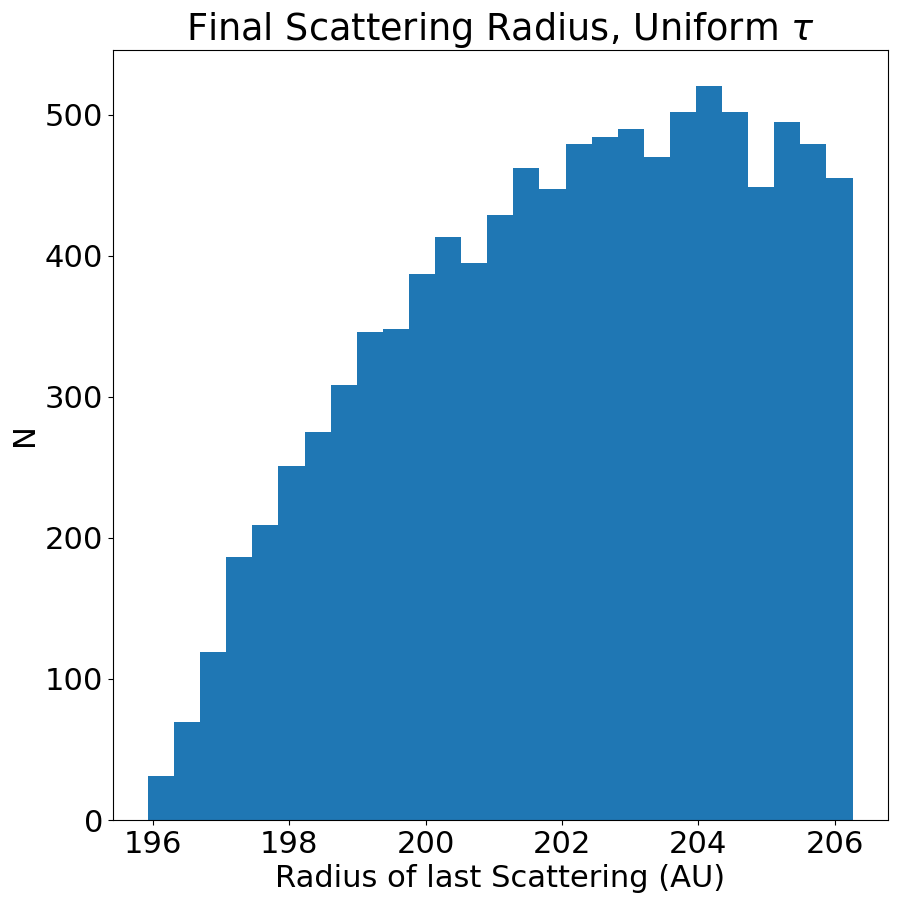

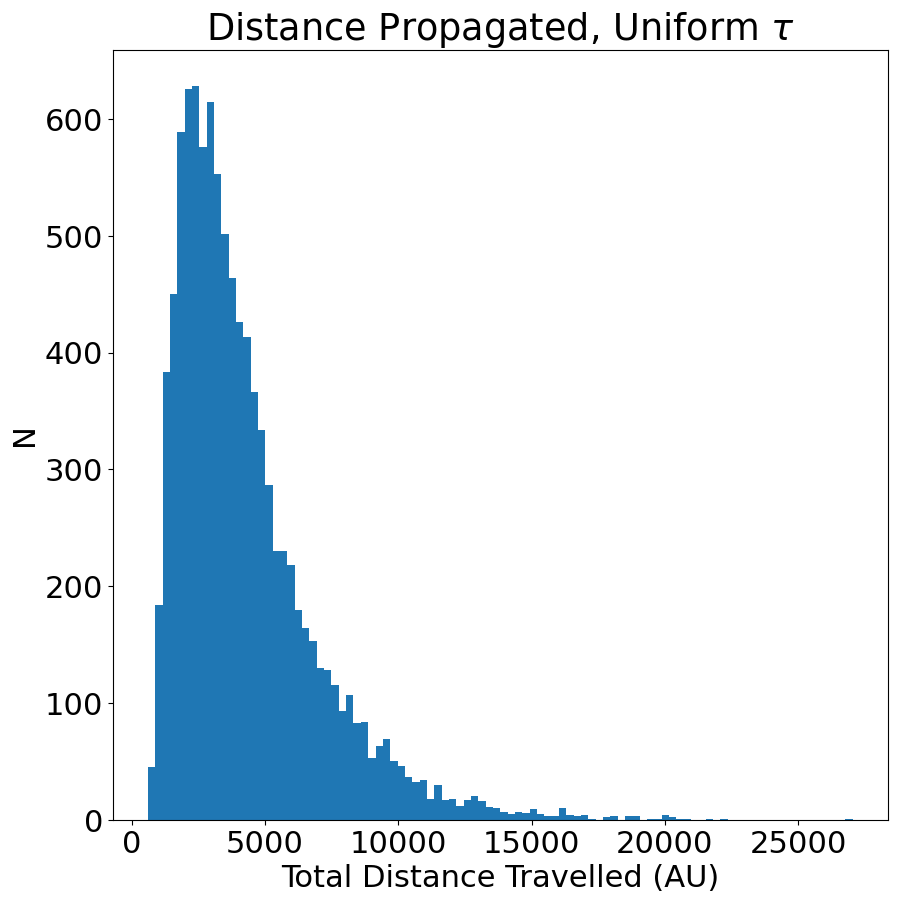

C:\Users\ceg30\Anaconda3\lib\site-packages\astropy\units\quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


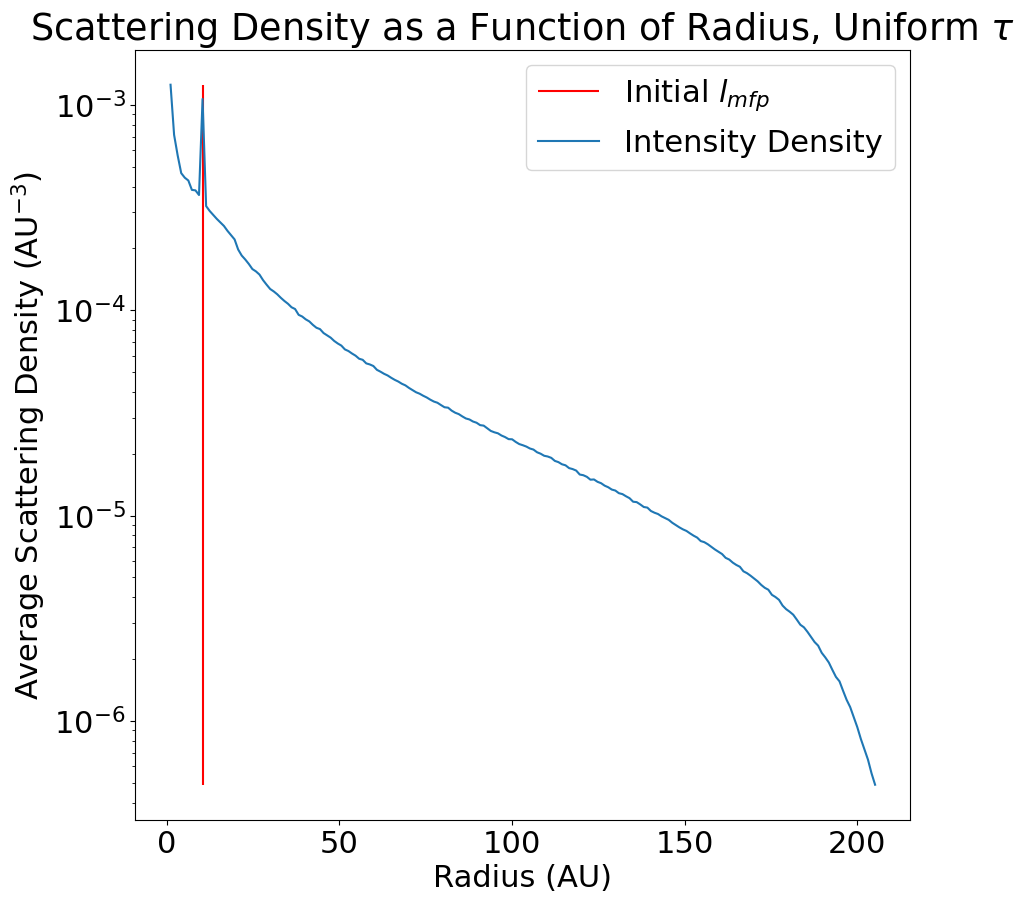

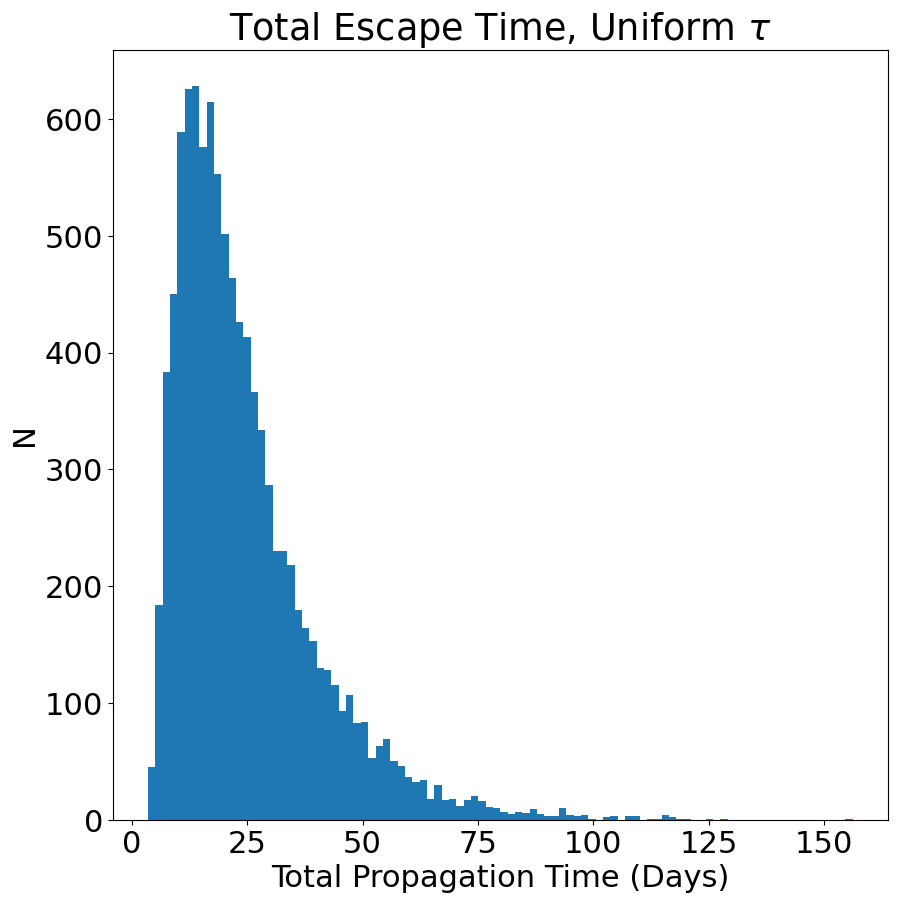

In [11]:
create_plot(l_func=l_uniform,string='Uniform')

99.99% completed


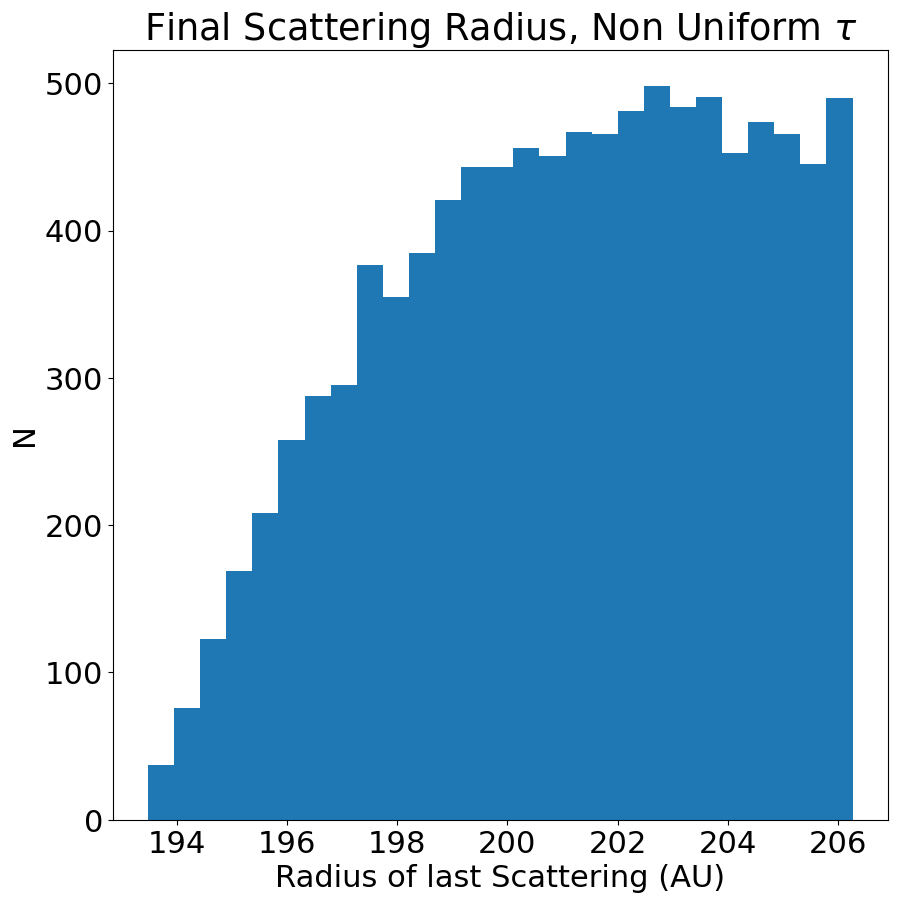

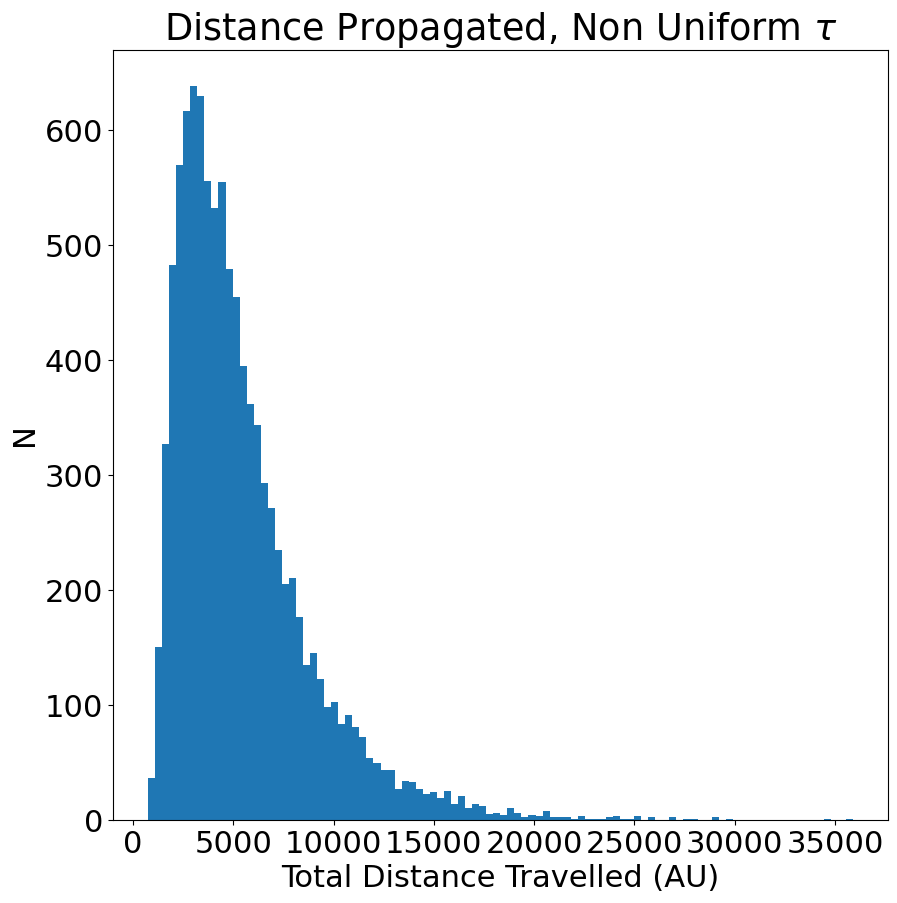

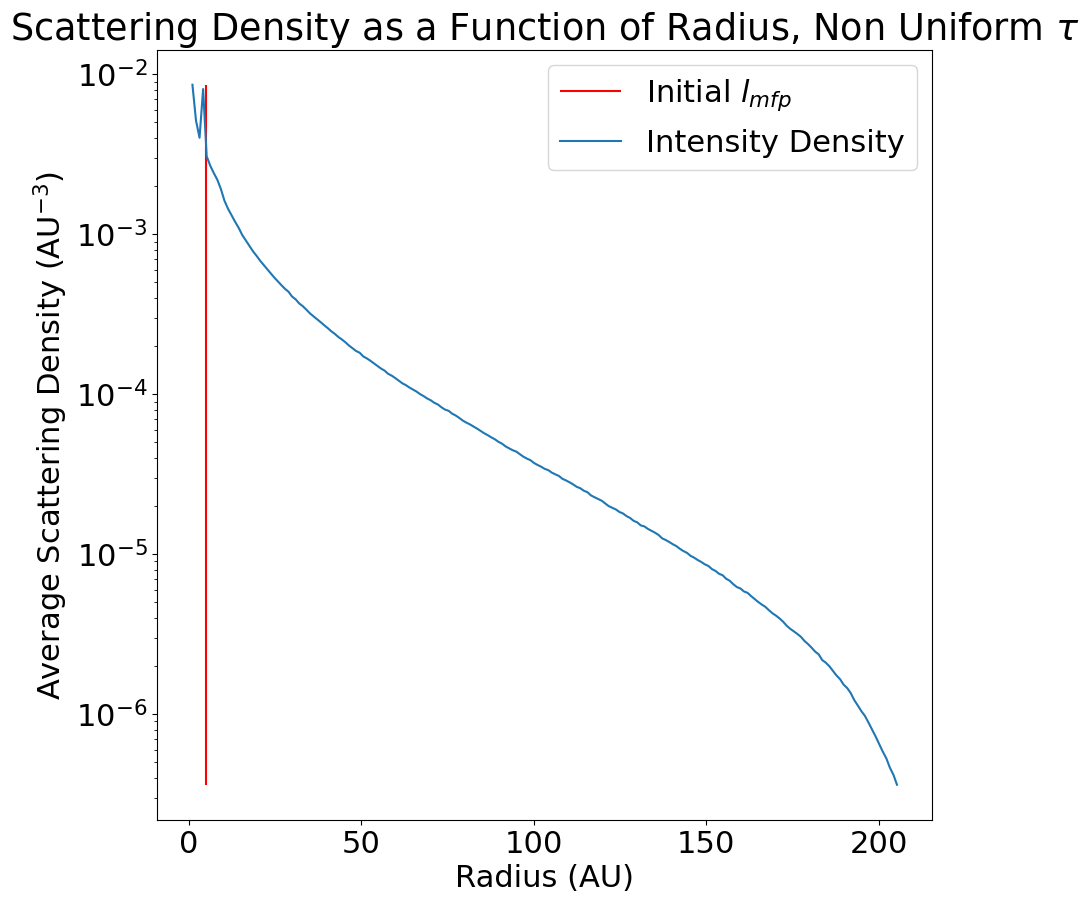

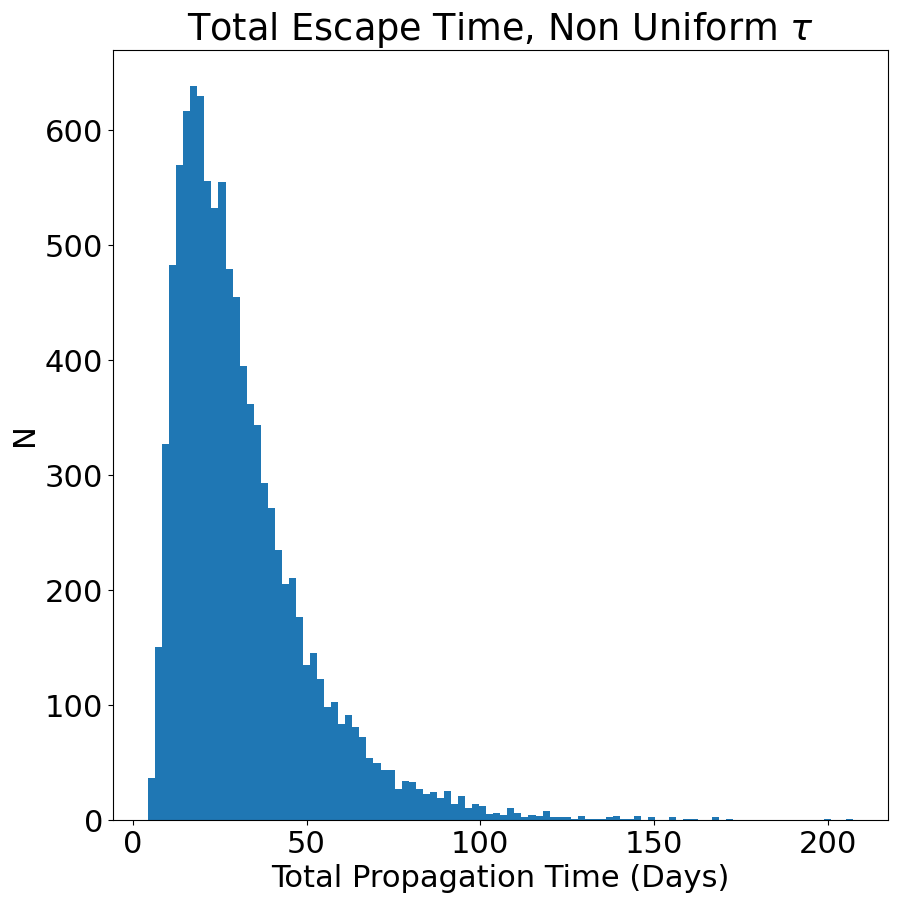

In [19]:
create_plot(l_func=l_non_uni,string='Non Uniform')

[Text(0.5, 0.92, '3D Random Walk For Uniform $\\tau$'),
 Text(0.5, 0, 'x (AU)'),
 Text(0.5, 0.5, 'y (AU)'),
 Text(0.5, 0, 'z (AU)')]

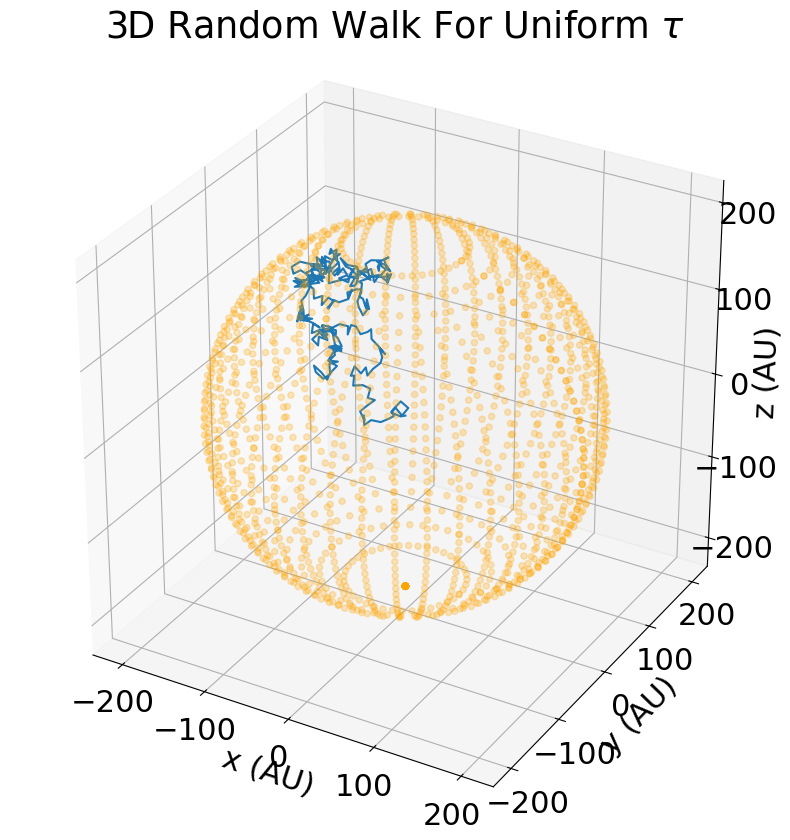

In [433]:
#create example path for uniform l
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

#find x, y, and z lists for the simulation
x,y,z,tot_l=propagate(l_func=l_uniform)

#plot the points
ax.plot(x/c.au.cgs,y/c.au.cgs,z/c.au.cgs)

#plot points on a sphere corresponding to the cloud boundary
plot_sphere(ax,n=40)
ax.set_aspect('equal')
ax.set(title='3D Random Walk For Uniform $\\tau$',xlabel='x (AU)',ylabel='y (AU)',zlabel='z (AU)')


[Text(0.5, 0.92, '3D Random Walk For Non Uniform $\\tau$'),
 Text(0.5, 0, 'x (AU)'),
 Text(0.5, 0.5, 'y (AU)'),
 Text(0.5, 0, 'z (AU)')]

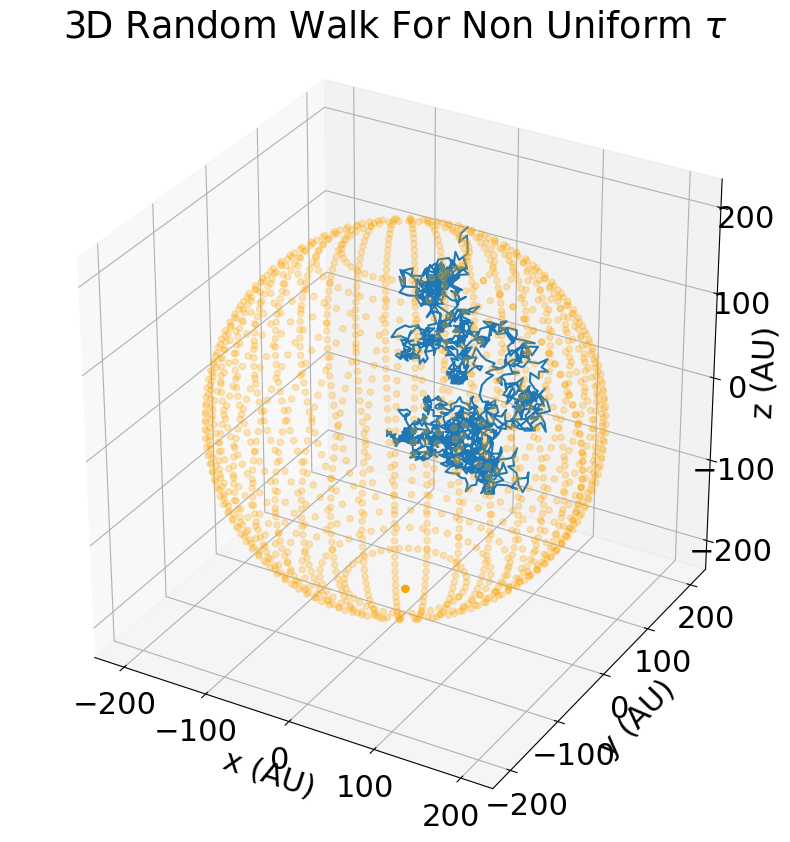

In [431]:
#create example path for non uniform l
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

#find x, y, and z lists for the simulation
x,y,z,tot_l=propagate(l_func=l_non_uni)

#plot the points
ax.plot(x/c.au.cgs,y/c.au.cgs,z/c.au.cgs)

#plot points on a sphere corresponding to the cloud boundary
plot_sphere(ax,n=40)
ax.set_aspect('equal')
ax.set(title='3D Random Walk For Non Uniform $\\tau$',xlabel='x (AU)',ylabel='y (AU)',zlabel='z (AU)')